In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from eval_util import *
from rec_util import *

/home/ellery/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


#Configuration

In [35]:
config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)

embedding_dir = 'en_lda'
embedding_path = os.path.join(cp.get('general', 'local_data_dir'), embedding_dir)

s = 'en'
t = 'fr'
exp = 'frwiki'
campaign = '%s-recommender' % exp
exp_dir = '%s-%s' % (s, t)
exp_path = os.path.join(cp.get('general', 'local_data_dir'), exp_dir)


#Load Editor Contribution Data

In [37]:
e_personal = pd.read_csv('/home/ellery/en-%s/e1.tsv' % t,  sep = '\t', encoding = 'utf8')
e_personal.index = e_personal['user']
#e_personal = pd.read_csv('/home/ellery/en-%s/e2.tsv' % t,  sep = '\t', encoding = 'utf8')
#e_personal.index = e_personal['user']

In [4]:
#e_personal = pd.read_csv('/home/ellery/en-%s/staff.tsv' % t,  sep = '\t', encoding = 'utf8')
#e_personal.columns = ['_', 'user', 'history', 'user_email']
#e_personal.index = e_personal['user']

# Refine and Split Articles

In [5]:
# load missing articles
translation_dict_file = os.path.join(exp_path, cp.get('missing', 'ranked_missing_items'))
a = pd.read_csv(translation_dict_file, sep = '\t', encoding = 'utf8')
a.index = a['id']
print "Num Missing Articles: ", a.shape[0]

Num Missing Articles:  3868598


In [6]:
# disambiguation
print "Num disambiguation", a['is_dis'].sum()
a = a[a['is_dis'] == False]
print "Num Missing Articles: ", a.shape[0]

Num disambiguation 67686
Num Missing Articles:  3800912


Stubs: 1613158
Full: 2187754


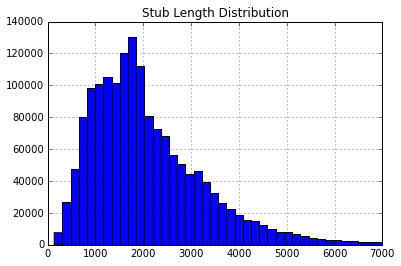

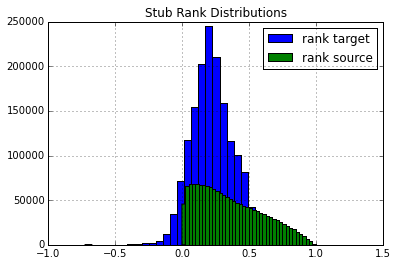

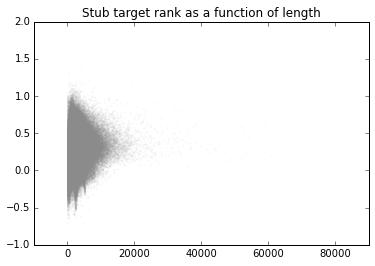

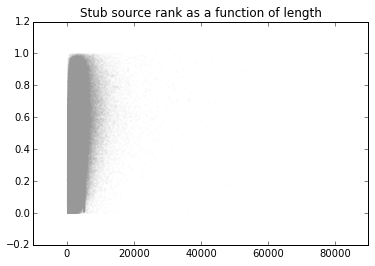

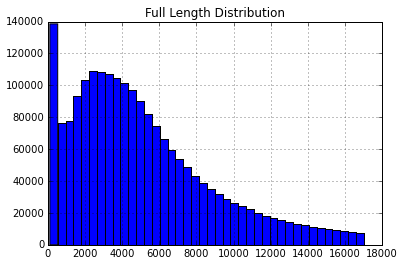

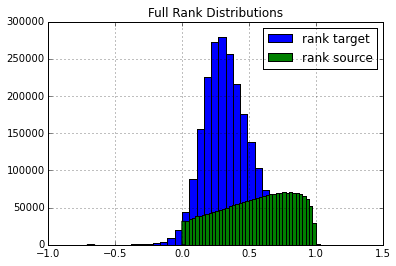

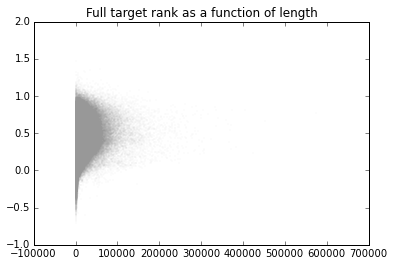

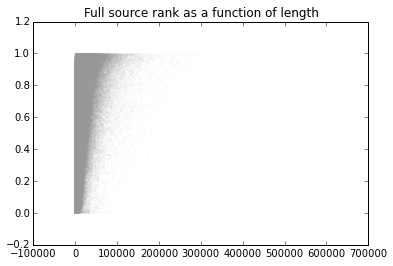

In [7]:
# remove short articles
plt.figure()

stub = a[a['is_stub']]
print "Stubs:", stub.shape[0]
full = a[~a['is_stub']]
print "Full:", full.shape[0]

# Investigate Stubs
plt.figure()
stub[stub['length'] < 7000]['length'].hist(bins = 40)
plt.title('Stub Length Distribution')

plt.figure()
stub['rank_t'].hist(bins = 40, label = 'rank target')
stub['rank_s'].hist(bins = 40, label = 'rank source')
plt.title('Stub Rank Distributions')
plt.legend()

plt.figure()
plt.scatter(stub['length'], stub['rank_t'], s=2, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Stub target rank as a function of length')


plt.figure()
plt.scatter(stub['length'], stub['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Stub source rank as a function of length')

#Investigat Full
plt.figure()
full[full['length'] < 17000]['length'].hist(bins = 40)
plt.title('Full Length Distribution')

plt.figure()
full['rank_t'].hist(bins = 40, label = 'rank target')
full['rank_s'].hist(bins = 40, label = 'rank source')
plt.title('Full Rank Distributions')
plt.legend()

plt.figure()
plt.scatter(full['length'], full['rank_t'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Full target rank as a function of length')


plt.figure()
plt.scatter(full['length'], full['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Full source rank as a function of length')

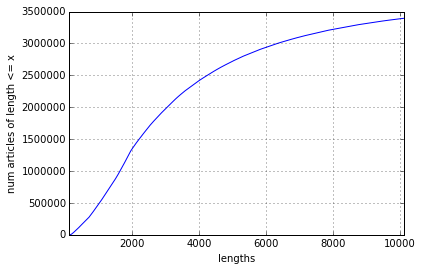

In [8]:
lengths = a['length'].value_counts()
lengths = lengths.sort_index()
lengths.cumsum()[:10000].plot()
plt.ylabel('num articles of length <= x')
plt.xlabel('lengths')

In [9]:
a = a[a['length'] > 1500]
print "Num Missing Articles: ", a.shape[0]

Num Missing Articles:  2923181


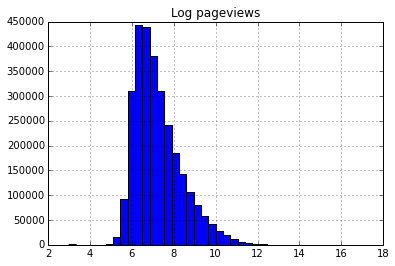

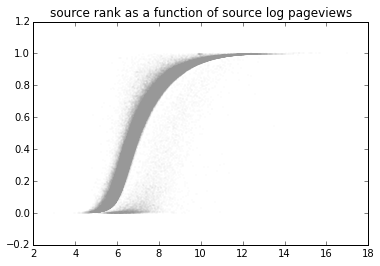

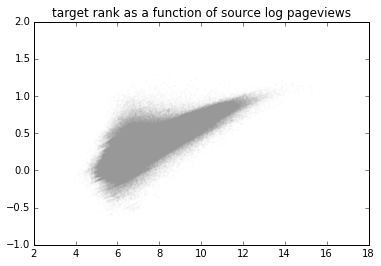

In [10]:
plt.figure()
a['log_pageview_count_s'].hist(bins = 40)
plt.title('Log pageviews')

plt.figure()
plt.scatter(a['log_pageview_count_s'], a['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('source rank as a function of source log pageviews')


plt.figure()
plt.scatter(a['log_pageview_count_s'], a['rank_t'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('target rank as a function of source log pageviews')

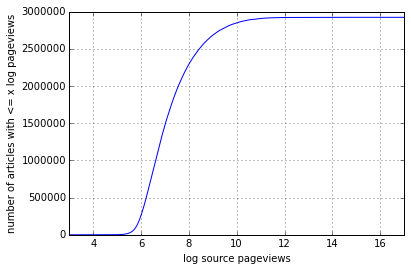

In [11]:
views = a['log_pageview_count_s'].value_counts()
views = views.sort_index()
views.cumsum().plot()
plt.xlabel('log source pageviews')
plt.ylabel('number of articles with <= x log pageviews')

In [12]:
thresh = 7.0
print np.exp(thresh)
(a['log_pageview_count_s'] > thresh).sum()

1096.63315843


1444225

In [13]:
a[a['log_pageview_count_s'] >= thresh][a['log_pageview_count_s'] <= thresh+0.1].head(10)

/home/ellery/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1808: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,id,title_s,pageview_count_s,log_pageview_count_s,indx,rank_s,length,is_dis,is_stub,log_length,rank_t
id,,,,,,,,,,,
Q16093343,Q16093343,Carlos_Eduardo_Jaramillo_Castillo,1167,7.062192,419287,0.538416,1944,False,False,7.572503,1.062154
Q7572949,Q7572949,Spain–Uruguay_relations,1209,7.097549,2195704,0.614324,3144,False,True,8.053251,1.054980
Q4589798,Q4589798,1994_Vuelta_a_Colombia,1139,7.037906,1784007,0.552427,14016,False,False,9.547955,1.044253
Q6309451,Q6309451,Julio_Olalla,1207,7.095893,119476,0.573708,3899,False,False,8.268475,1.026008
Q7121790,Q7121790,Pablo_de_Coronel,1147,7.044905,4460789,0.551335,2430,False,True,7.795647,1.022124
Q4736967,Q4736967,Altos_de_Arroyo_Hondo,1158,7.054450,707929,0.555007,1884,False,True,7.541152,1.019559
Q1364133,Q1364133,Roman_Catholic_Archdiocese_of_Belém_do_Pará,1115,7.016610,1570219,0.593483,4885,False,False,8.493925,1.008461
Q10322705,Q10322705,Macarena_(telenovela),1097,7.000334,1273989,0.564635,3145,False,False,8.053569,0.989382
Q4671079,Q4671079,Academia_Nacional_de_Medicina,1122,7.022868,2184125,0.544173,11010,False,False,9.306559,0.974826


In [14]:
a = a[a['log_pageview_count_s'] > thresh]
print "Num Missing Articles: ", a.shape[0]

Num Missing Articles:  1444225


In [15]:
# now create a stratified sample
a = a.sort('rank_t', ascending = False)
a_control = a.iloc[range(0, a.shape[0], 3)]
a_personal = a.iloc[range(1, a.shape[0], 3)]
a_random = a.iloc[range(2, a.shape[0], 3)]

#Load Doc Topic Matrices

In [16]:
embedding_dict_file = os.path.join(embedding_path, cp.get('LDA', 'article2index'))
id2index, index2id, id2uname = get_universal_maps(embedding_dict_file)
mm_file = os.path.join(embedding_path, cp.get('LDA', 'doc2topic'))
f = open(mm_file)
M = mmread(f).tocsr()
M = normalize(M, norm='l2', axis=1)

In [17]:
id2sname = dict(zip(a['id'], a['title_s']))

# Find Minimum Number of Articles:

Optimization took 0 seconds
0.727883529271


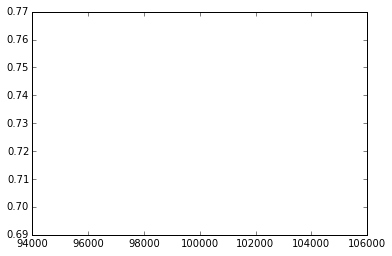

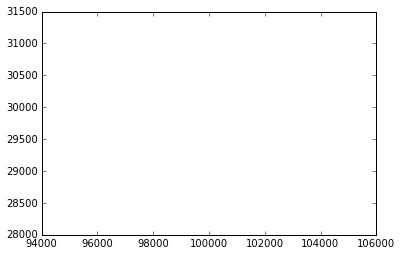

In [38]:
k = 5
greedy = True 
max_articles_per_editor = 1000
max_num_editors = e_personal.shape[0]
min_score = 0.4
mean_affinities = []
num_matches = []
num_editors = e_personal.shape[0]
n_articles = [k*num_editors * i for i in range(1, 12, 2)]
n_articles = [100000]
for n in n_articles:
    it = contribution_iter(e_personal['history'][:max_num_editors])
    a_personal_topn = a_personal[:n]
    id2importance = dict(zip(a_personal_topn['id'], np.ones(a_personal_topn.shape[0])))
    contributions = get_affinities(M,it, max_articles_per_editor, min_score, id2importance, id2index, index2id)
    if greedy:
        obj, d = greedy_match(contributions, k)
        print obj   
    else:
        editor_ids, article_ids, affinities = get_matching_data_structures(contributions)
        print "Number of Affinites", len (affinities)
        obj, d = match(editor_ids, article_ids, affinities, k )
    mean_affinities.append(obj)
    num_matches.append(d.shape[0])
    #print d

plt.figure()
plt.plot(n_articles, mean_affinities)
plt.figure()
plt.plot(n_articles, num_matches)

In [39]:
personal_objs = get_json(e_personal, d, id2sname, contributions, campaign, s, t, k)


There were 154 users without 5 recs


In [40]:
(e_personal['user'] == 'Racinaire').sum()

1

In [41]:
e_personal.head()

,Unnamed: 0,user,history,user_email
user,,,,
Yakapedia,0,Yakapedia,"{""uname"": ""Yakapedia"", ""contributions"": [{""pag...",sndrliebermann4@gmail.com
Euthy,1,Euthy,"{""uname"": ""Euthy"", ""contributions"": [{""page_ti...",jerome@ec-network.net
JD,2,JD,"{""uname"": ""JD"", ""contributions"": [{""page_title...",JD_wp@gmx.de
Wikijens,3,Wikijens,"{""uname"": ""Wikijens"", ""contributions"": [{""page...",wikijens@gmail.com
Simonemb,4,Simonemb,"{""uname"": ""Simonemb"", ""contributions"": [{""page...",simone_pl@hotmail.it


In [44]:
for c in personal_objs:
    if c['user'] == 'Xavier Combelle':
        pprint_rec(c)
    

#Perform Editor Article Assignment

In [19]:
n = 100000
k = 5
greedy = True 
max_articles_per_editor = 3000
min_score = 0.2
w = 15
it = contribution_iter(e_personal['history'])
a_personal_topn = a_personal[:n]
id2importance = dict(zip(a_personal_topn['id'], np.ones(a_personal_topn.shape[0])))
contributions = get_affinities(M,it, max_articles_per_editor, min_score, id2importance, id2index, index2id, w = w)
objective, d_personal = greedy_match(contributions, k)

print objective, d_personal.shape, e_personal.shape[0] * k

personal_objs = get_json(e_personal, d_personal, id2sname, contributions, campaign, s, t, k)
fname = "/home/ellery/%s/%s-personal-recs.json" % (exp_dir, exp)
with open(fname, 'w') as outfile:
    json.dump(personal_objs, outfile)
    
i = 0
for obj in personal_objs:
    pprint_rec(obj)
    i+=1
    if i==10:
        break
        
i = 0
for obj in personal_objs:
    pprint(obj)
    i+=1
    if i==10:
        break

Optimization took 0 seconds
0.736664503263 (19030, 3) 19055
There were 0 users without 5 recs
User: -dam-

History:

Tomás_Boy
Manuel_Velasco_Coello
Daniel_Brühl
Alan_Pulido
Desaparición_forzada_en_Iguala_de_2014
Alfonso_Cuarón
Augusto_Monterroso
Alejandro_González_Iñárritu
Eduardo_Sánchez_Hernández
Miguel_Alcubierre
Claudia_Pavlovich_Arellano
Masacre_de_la_Escuela_Secundaria_de_Columbine
Swift_(lenguaje_de_programación)
Javier_Hernández_Balcázar
Real_Madrid_Club_de_Fútbol

Recommendations:

Love_and_Co 0.725871435814
History_of_Fear 0.717477991352
Linha_de_Passe 0.682302859632
Arena_(2009_film) 0.60089303005
Javi_Cantero 0.532960109511



User: .mau.

History:

Desmond_Cory
1970_Summer_Universiade
Dastardly_and_Muttley_in_Their_Flying_Machines
Fravia
Sideloading
Conway_base_13_function
Penney's_game
Long_division
Kurt_Gödel
Reference.com
Mostafa_Mohammad-Najjar
Szemerédi's_theorem
Doomsday_argument
Fiber_to_the_x
76_(number)

Recommendations:

Middle-square_method 0.821233777369
Web_M

# Create Random Recommendations

In [20]:
it = contribution_iter(e_random['history'])
contributions = {}
for i, contribution in enumerate(it):
    contribution['contributions'] = [d for d in contribution['contributions'] if d['id'] in id2index][-w:]
    contributions[contribution['uname']] = contribution


a_random_topn = a_random[:n]
a_random_topn = a_random_topn.iloc[np.random.permutation(len(a_random_topn))]
a_random_topn.reset_index(drop=True)

d_random = []
i = 0
for user in e_random.index:
    c = contributions[user]
    interest_vec = get_weighted_average_interest_vector(M, id2index, None, c)
    for j in range(k):
        doc_vec = np.asarray(M[ a_random_topn.iloc[i]['indx'], :].todense()).squeeze()
        score = interest_vec.dot(doc_vec)
        d_random.append((user, a_random_topn.iloc[i]['id'], score ))
        i+=1
d_random = pd.DataFrame(d_random)    
random_objs = get_json(e_random, d_random, id2sname, contributions, campaign, s, t, k)

fname = "/home/ellery/%s/%s-random-recs.json" % (exp_dir, exp)
with open(fname, 'w') as outfile:
    json.dump(random_objs, outfile)

    
i = 0
for obj in random_objs:
    pprint_rec(obj)
    i+=1
    if i==10:
        break
        
i = 0
for obj in random_objs:
    pprint(obj)
    i+=1
    if i==10:
        break

There were 0 users without 5 recs
User: -Erick-

History:

Sportacus
Javier_Hernández
Oro_de_Moscú
Desaparición_forzada_en_Iguala_de_2014
Himno_Nacional_Mexicano
Alejandro_González_Iñárritu
Municipio_de_Tuxpan_(Veracruz)
Juan_Ramón_de_la_Fuente
Planta_de_energía_geotérmica_Cerro_Prieto
1906
1907
Banderas_monumentales_de_México
Camino_Real_de_Tierra_Adentro
Monólogo
Julio_César_Godoy_Toscano

Recommendations:

Copyright_status_of_work_by_U.S._subnational_governments 0.15233191234
Robert_Serber 0.0600790532053
Fuji_GX680 0.0109715131659
Russian_Braille 0.099955155583
Young_Apprentice 0.0718603186242



User: -jem-

History:

Años_2010
Economía
Tarek_Aziz
Difusión
Día_de_las_Américas
Valladolid
Bypass
Día_del_abuelo
Jaime_de_Marichalar
Isabel_Pantoja
2015
Kristoff_Raczynski
Pedro
2018
Traducción

Recommendations:

Mumbai_Police 0.0956700778704
Inolvidable_(song) 0.439357497497
Thermogenin 0.0150294990567
Allwinner_A1X 0.183172476852
NYPD_Blue_(season_7) 0.197582259477



User: -kayac71-



In [21]:
a_control[:n].to_csv('/home/ellery/%s/%s-control_articles.csv' %  (exp_dir, exp), encoding = 'utf8', sep='\t')

#Scratch

In [22]:
d_random.head(10)

,0,1,2
0,Simo ubuntu,Q5591554,0.000000
1,Simo ubuntu,Q4363053,0.005754
2,Simo ubuntu,Q16247425,0.002396
3,Simo ubuntu,Q469708,0.000000
4,Simo ubuntu,Q2093909,0.009698
5,Kruusamägi,Q1995193,0.020541
6,Kruusamägi,Q6717083,0.002124
7,Kruusamägi,Q1653284,0.004218
8,Kruusamägi,Q4781182,0.026302
9,Kruusamägi,Q4756956,0.008157


In [23]:
#verify no repeat recs
d_personal.merge(d_random, on = 1, how='inner').shape

(0, 5)

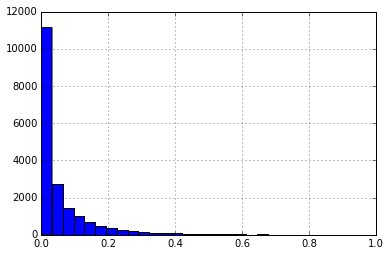

In [24]:
d_random[2].hist(bins = 30)

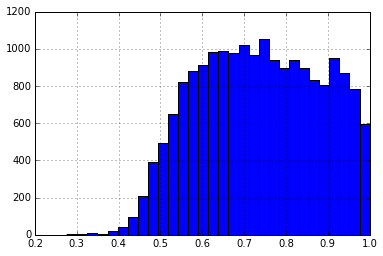

In [25]:
d_personal[2].hist(bins = 30)

In [ ]:
it = contribution_iter(e_random['history'])
tuples = []
for i, contribution in enumerate(it):
    pre = len(contribution['contributions'])
    post = len([d for d in contribution['contributions'] if d['id'] in id2index])
    tuples.append((pre, post))
   

In [ ]:
pp = pd.DataFrame(tuples)

In [ ]:
print sum(pp[0] == 0)

pp[0].hist()

In [ ]:
print sum(pp[1] == 0)
pp[1].hist(bins = 30)

In [ ]:
((pp[0] - pp[1]) / pp[0]).hist( bins = 50)